<a href="https://colab.research.google.com/github/Leeyeji13/Section2_project/blob/main/AI_13_%EC%9D%B4%EC%98%88%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 항공 이용 고객 만족도 분류

## < 데이터 업로드 >

In [1]:
!pip install pandas-profiling==3.1.0

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [419]:
from google.colab import files
import pandas as pd
import io
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rc('font', family='NanumBarunGothic')

In [4]:
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving train.csv to train (2).csv


Saving test.csv to test (2).csv


In [420]:
train = pd.read_csv(io.StringIO(uploaded1['train.csv'].decode('utf8')))
test = pd.read_csv(io.StringIO(uploaded2['test.csv'].decode('utf8')))

In [421]:
train.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [422]:
test.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [423]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [424]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

## <타겟 특성의 불균형 확인>

In [425]:
train['satisfaction'].value_counts(normalize = True)

neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: satisfaction, dtype: float64

Text(0.5, 1.0, "Passengers' Satisfaction Rate")

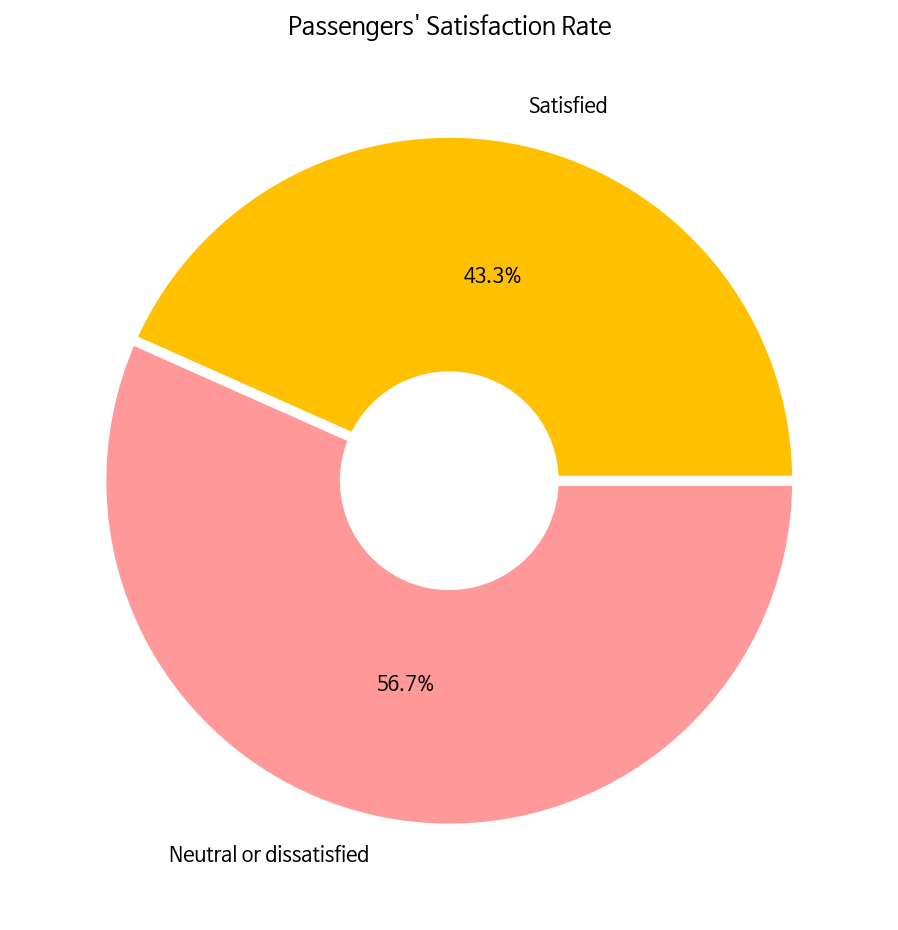

In [426]:
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.figure(figsize=(8, 8))
train['satisfaction'].value_counts().plot(kind = "pie", autopct = '%1.1f%%', colors = ['#ff9999', '#ffc000'], counterclock = False, wedgeprops = wedgeprops, labels = ["Neutral or dissatisfied", "Satisfied"])
plt.ylabel("")
plt.title("Passengers' Satisfaction Rate")

***=> Baseline : 0.57***

## < 결측치 >

In [427]:
train.isna().sum()
## Arrival_Delay_Minutes 만 있는 걸로 파악됨.
## test에도 결측치가 있으므로 제거보다는 대체하는 것이 좋을 것으로 판단.
## 최빈값이나 평균보다는 0으로 대체하는 것이 적절하다고 판단.

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [428]:
test.isna().sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


In [429]:
train['Arrival Delay in Minutes'] = train['Arrival Delay in Minutes'].fillna(0)
test['Arrival Delay in Minutes'] = test['Arrival Delay in Minutes'].fillna(0)

In [430]:
train.isna().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [431]:
test.isna().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

## < 시각화 >

In [432]:
train = train.drop(['Unnamed: 0', 'id'], axis = 1)
test = test.drop(['Unnamed: 0', 'id'], axis = 1)
train.shape, test.shape

((103904, 23), (25976, 23))

In [433]:
train.columns = [c.replace(' ','_') for c in train.columns]
test.columns = [c.replace(' ','_') for c in test.columns]

## < 범주형 특성 인코딩 >

In [434]:
train.dtypes == 'object'

Gender                                True
Customer_Type                         True
Age                                  False
Type_of_Travel                        True
Class                                 True
Flight_Distance                      False
Inflight_wifi_service                False
Departure/Arrival_time_convenient    False
Ease_of_Online_booking               False
Gate_location                        False
Food_and_drink                       False
Online_boarding                      False
Seat_comfort                         False
Inflight_entertainment               False
On-board_service                     False
Leg_room_service                     False
Baggage_handling                     False
Checkin_service                      False
Inflight_service                     False
Cleanliness                          False
Departure_Delay_in_Minutes           False
Arrival_Delay_in_Minutes             False
satisfaction                          True
dtype: bool

In [435]:
for col in train.select_dtypes(include=['object']).columns:
      print(col , " : " , train[col].unique())
##원핫인코딩보다는 라벨인코딩이 낫다고 판단

Gender  :  ['Male' 'Female']
Customer_Type  :  ['Loyal Customer' 'disloyal Customer']
Type_of_Travel  :  ['Personal Travel' 'Business travel']
Class  :  ['Eco Plus' 'Business' 'Eco']
satisfaction  :  ['neutral or dissatisfied' 'satisfied']


In [436]:
for col in test.select_dtypes(include=['object']).columns:
      print(col , " : " , test[col].unique())

Gender  :  ['Female' 'Male']
Customer_Type  :  ['Loyal Customer' 'disloyal Customer']
Type_of_Travel  :  ['Business travel' 'Personal Travel']
Class  :  ['Eco' 'Business' 'Eco Plus']
satisfaction  :  ['satisfied' 'neutral or dissatisfied']


In [437]:
test.dtypes == 'object'

Gender                                True
Customer_Type                         True
Age                                  False
Type_of_Travel                        True
Class                                 True
Flight_Distance                      False
Inflight_wifi_service                False
Departure/Arrival_time_convenient    False
Ease_of_Online_booking               False
Gate_location                        False
Food_and_drink                       False
Online_boarding                      False
Seat_comfort                         False
Inflight_entertainment               False
On-board_service                     False
Leg_room_service                     False
Baggage_handling                     False
Checkin_service                      False
Inflight_service                     False
Cleanliness                          False
Departure_Delay_in_Minutes           False
Arrival_Delay_in_Minutes             False
satisfaction                          True
dtype: bool

In [438]:
def categorical_encoding(df):
  lencoders = {}
  for col in df.select_dtypes(include=['object']).columns:
      lencoders[col] = LabelEncoder()
      df[col] = lencoders[col].fit_transform(df[col])

In [439]:
categorical_encoding(train)
categorical_encoding(test)

In [440]:
train.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1,0,13,1,2,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,0,0,26,0,0,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,0,0,25,0,0,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,1,0,61,0,0,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [441]:
test.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,0,0,52,0,1,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,1
1,0,0,36,0,0,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,1
2,1,1,20,0,1,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,0
3,1,0,44,0,0,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,1
4,0,0,49,0,1,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,1


## < 이상치 확인 >

In [442]:
train.describe()
#이상치 확인 결과 => 데이터의 개수 똑같고, 각 컬럼에 맞게 min, max 적절하다고 판단. -> 이상치 제거 필요 X 판단

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,...,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,0.492541,0.182678,39.379706,0.310373,0.594135,1189.448375,2.729683,3.060296,2.756901,2.976883,...,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.133392,0.433333
std,0.499947,0.386404,15.114964,0.462649,0.620799,997.147281,1.327829,1.525075,1.398929,1.277621,...,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.649776,0.495538
min,0.000000,0.000000,7.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,0.000000,0.000000,414.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,40.000000,0.000000,1.000000,843.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,51.000000,1.000000,1.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,1.000000,1.000000,85.000000,1.000000,2.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


In [443]:
test.describe()
#이상치 확인 결과 => 데이터의 개수 똑같고, 각 컬럼에 맞게 min, max 적절하다고 판단. -> 이상치 제거 필요 X 판단

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,...,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25976.000000,25976.000000
mean,0.492917,0.184747,39.620958,0.305590,0.592778,1193.788459,2.724746,3.046812,2.756775,2.977094,...,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.693756,0.438982
std,0.499959,0.388100,15.135685,0.460666,0.623703,998.683999,1.335384,1.533371,1.412951,1.282133,...,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.466787,0.496272
min,0.000000,0.000000,7.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,0.000000,0.000000,414.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,40.000000,0.000000,1.000000,849.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,51.000000,1.000000,1.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000,1.000000
max,1.000000,1.000000,85.000000,1.000000,2.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.00000,1115.000000,1.000000


In [444]:
def check_outlier(df):
  for col in df.columns:
      sns.boxplot(df[col])
      plt.show()

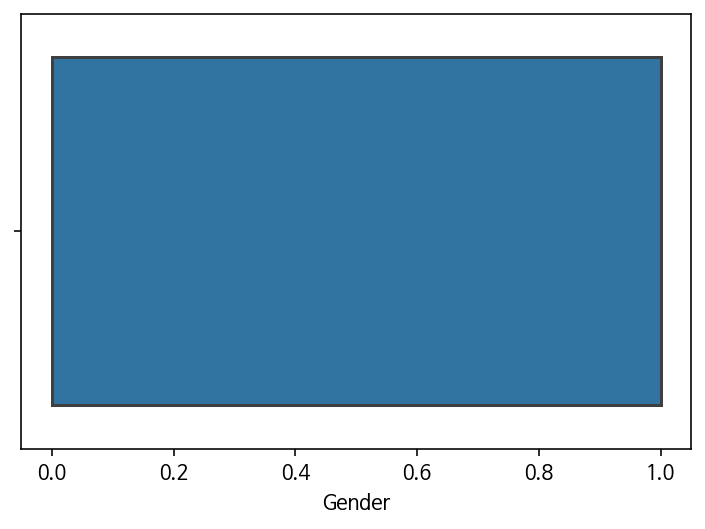

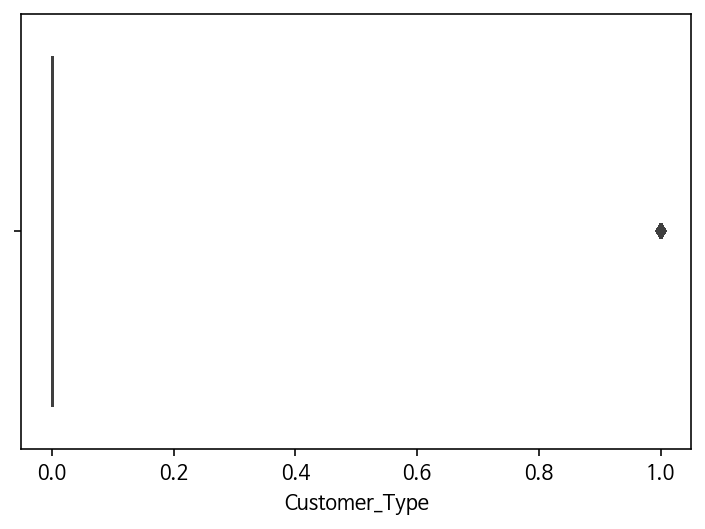

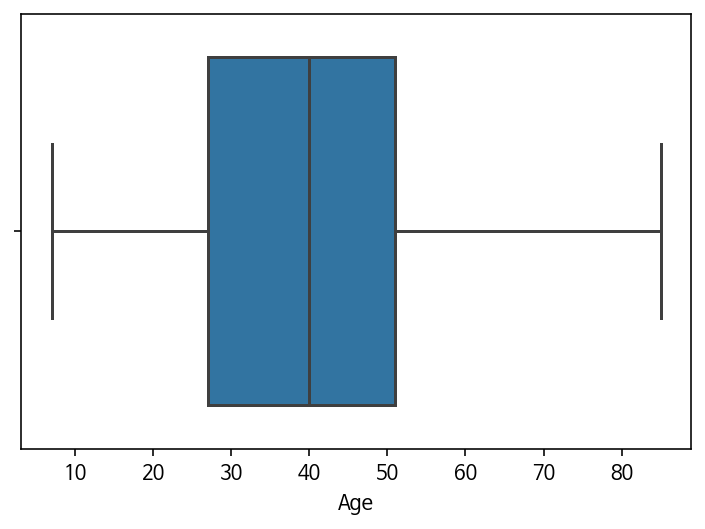

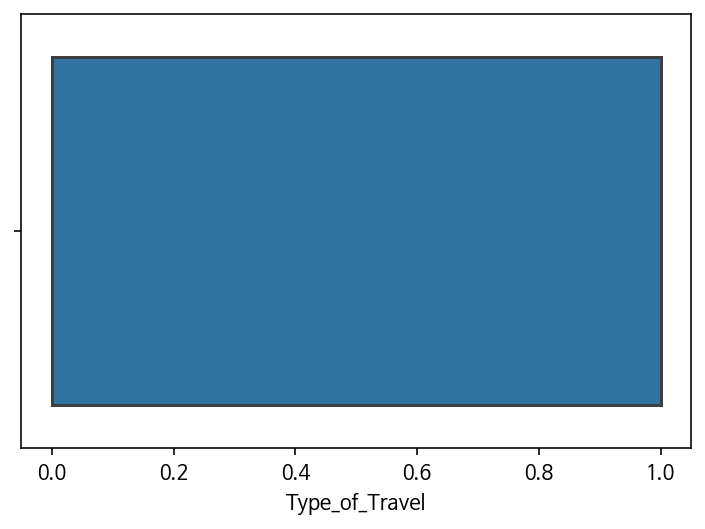

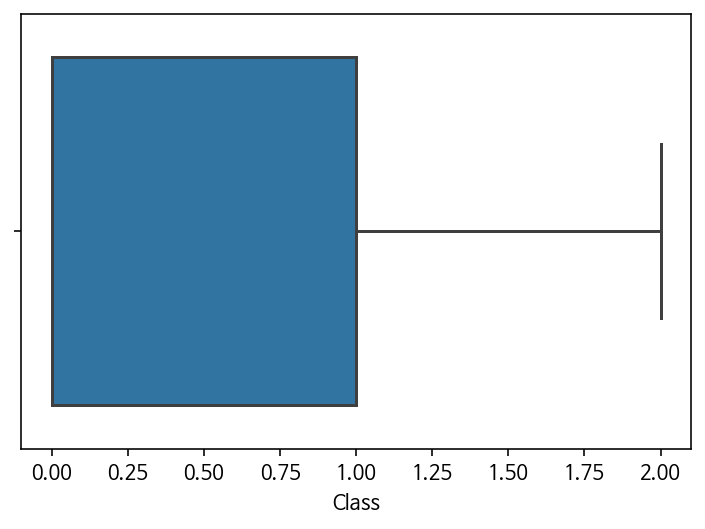

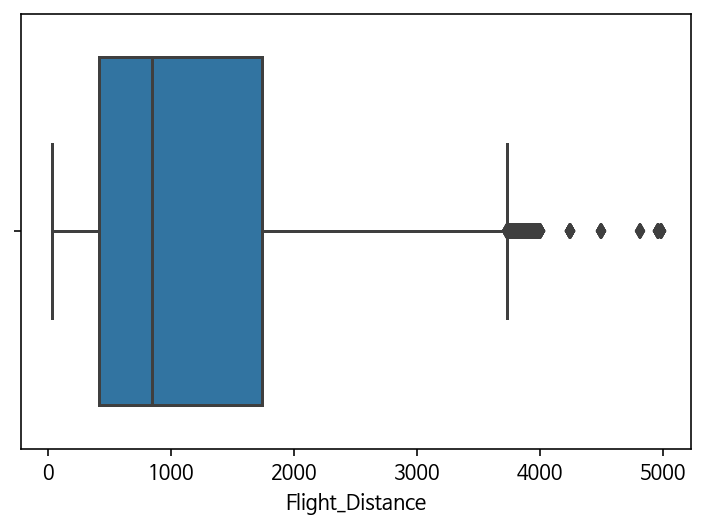

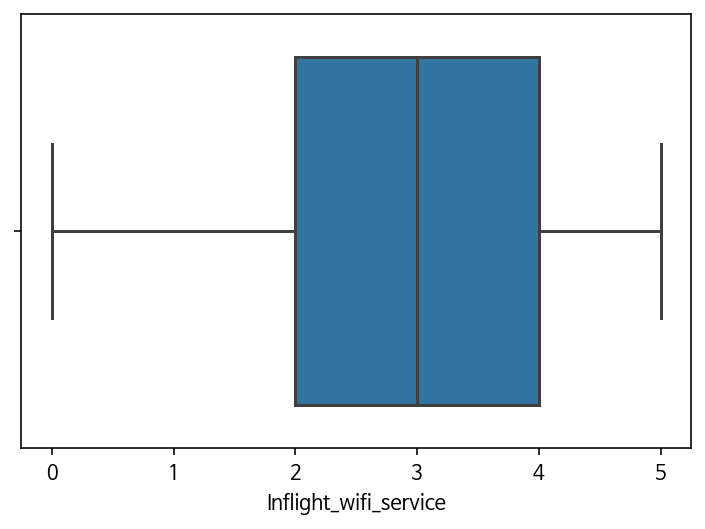

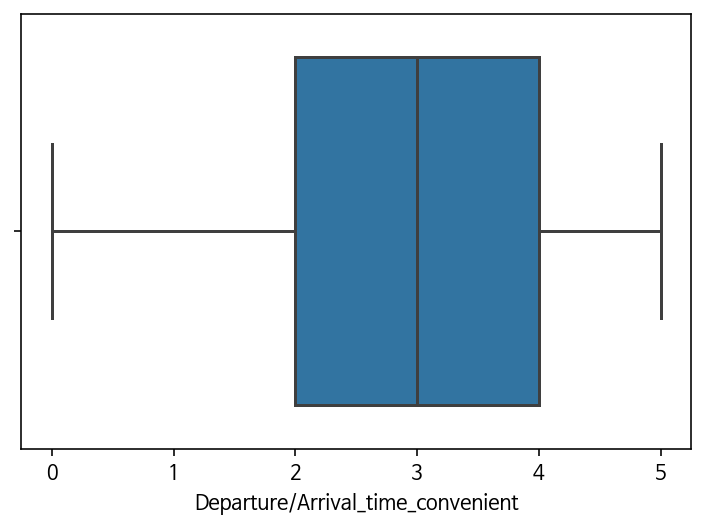

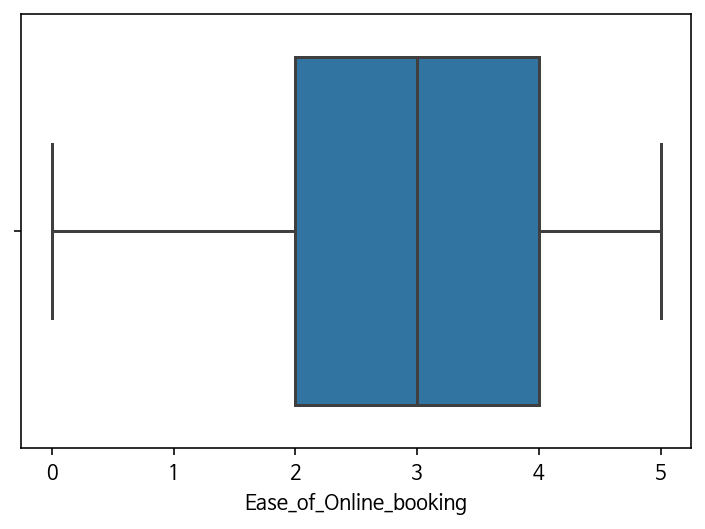

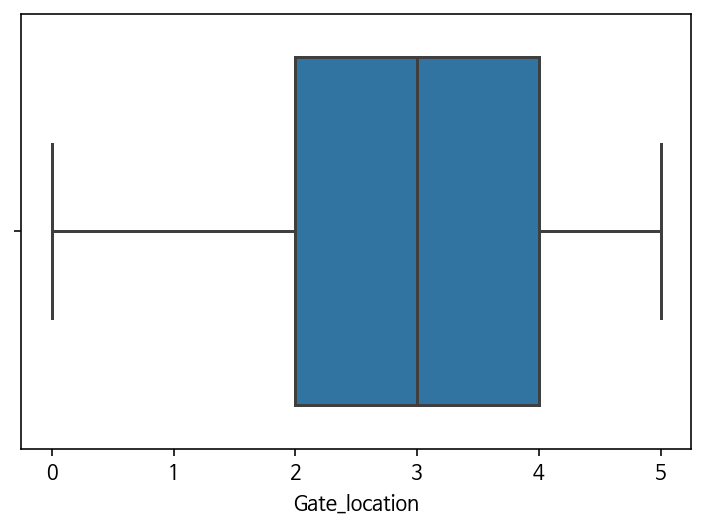

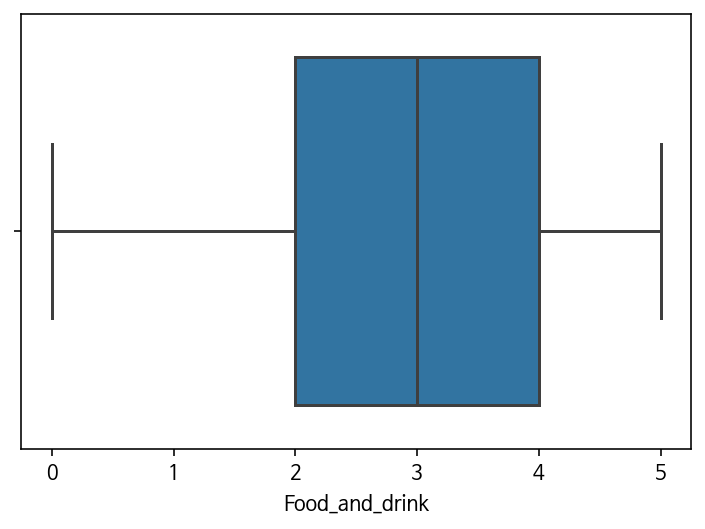

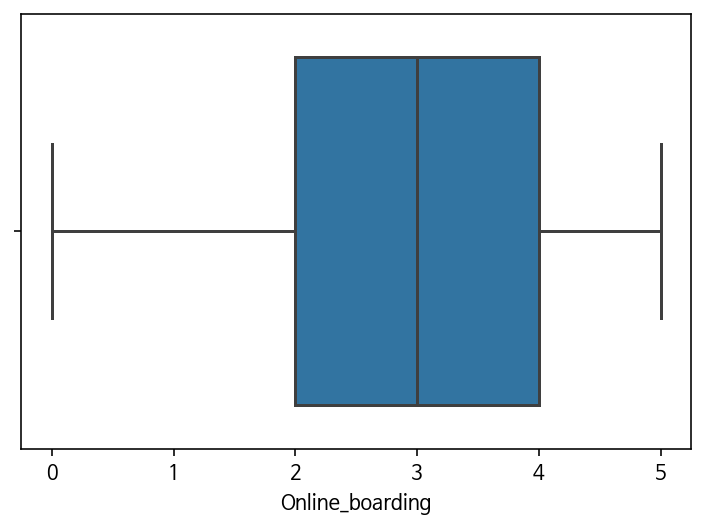

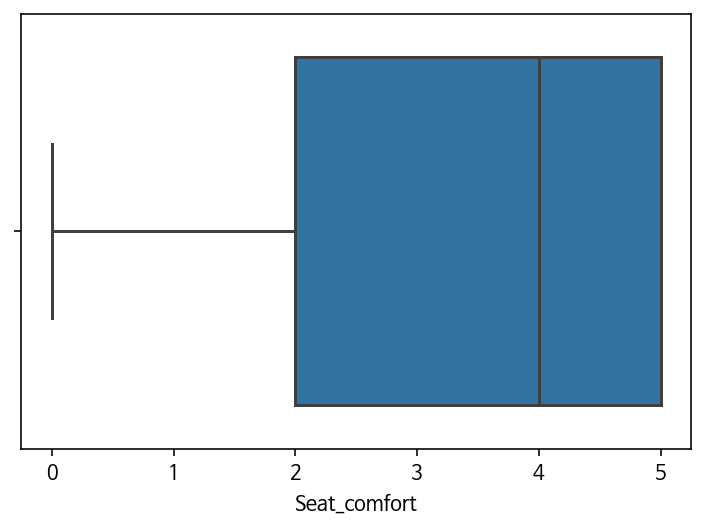

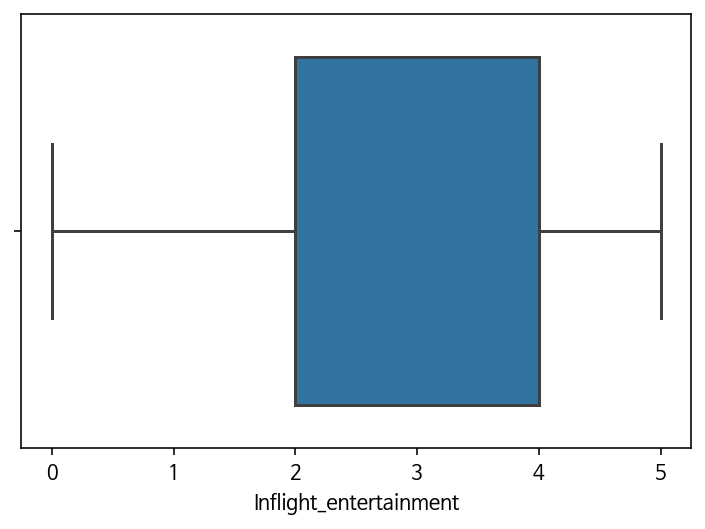

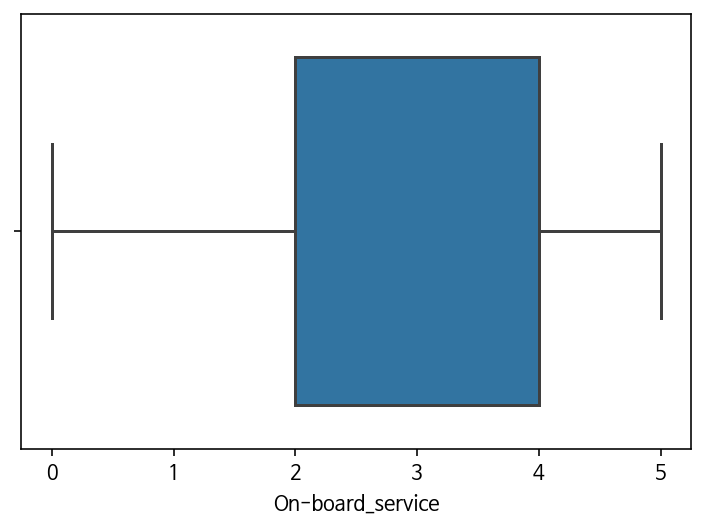

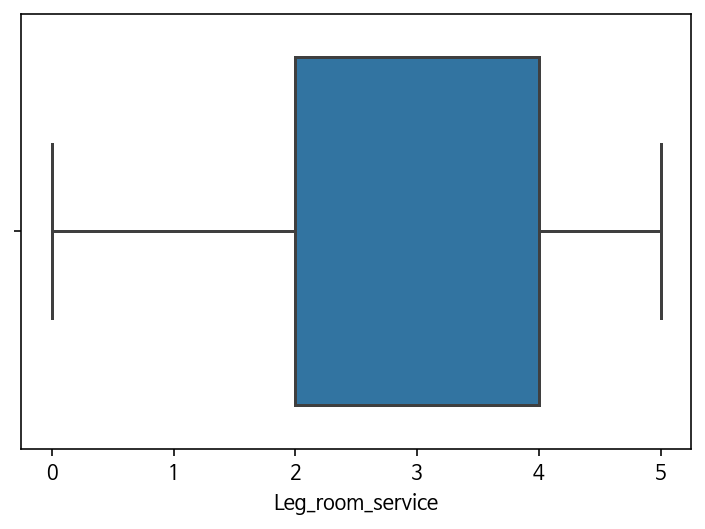

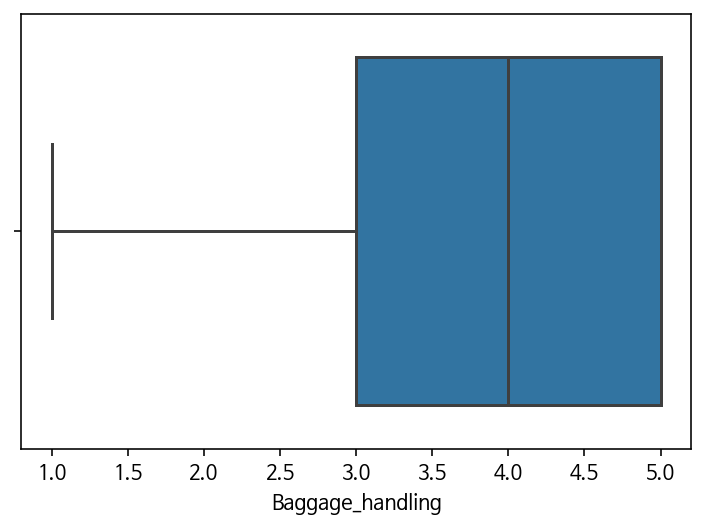

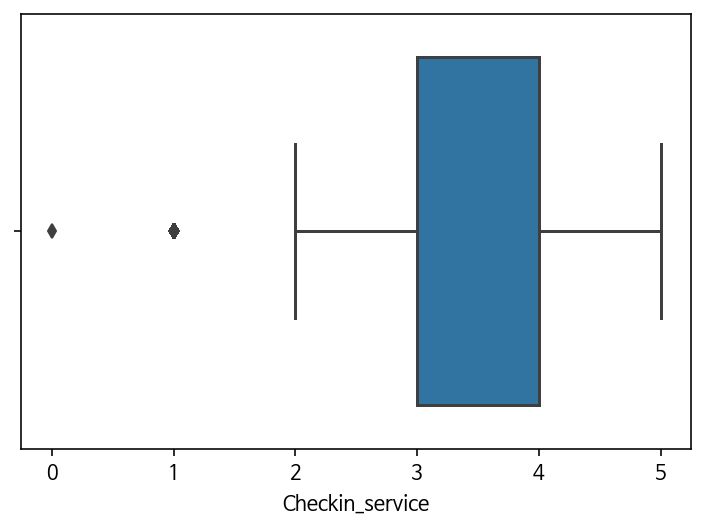

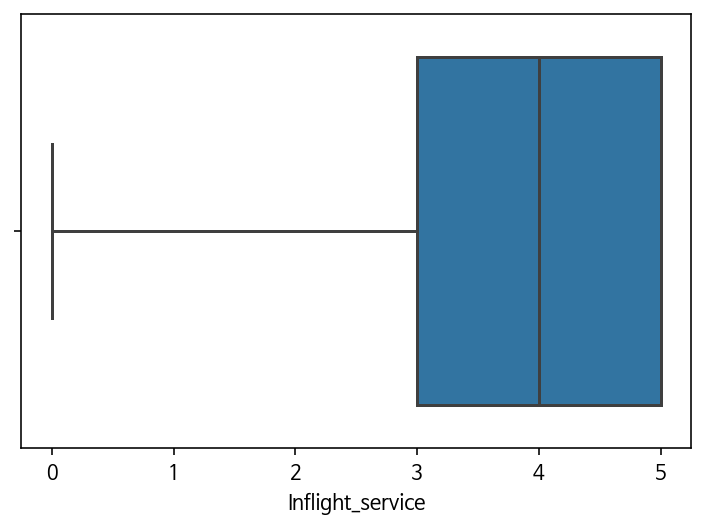

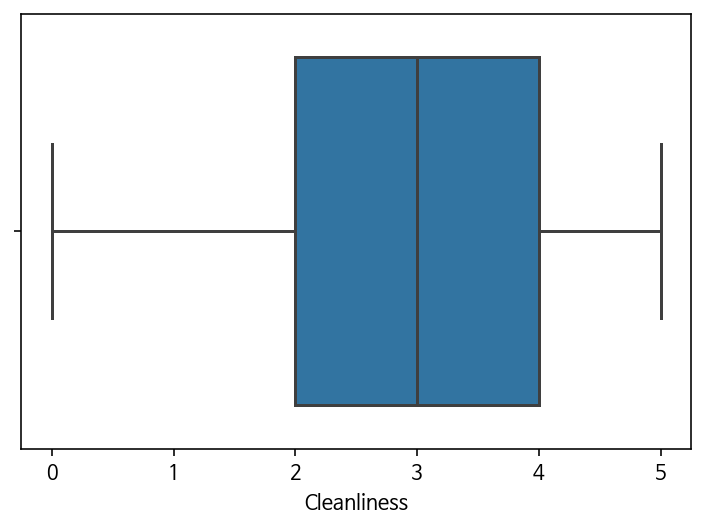

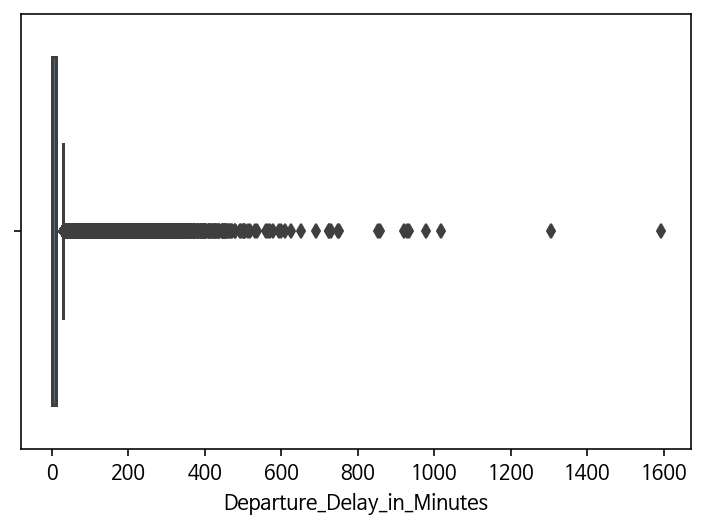

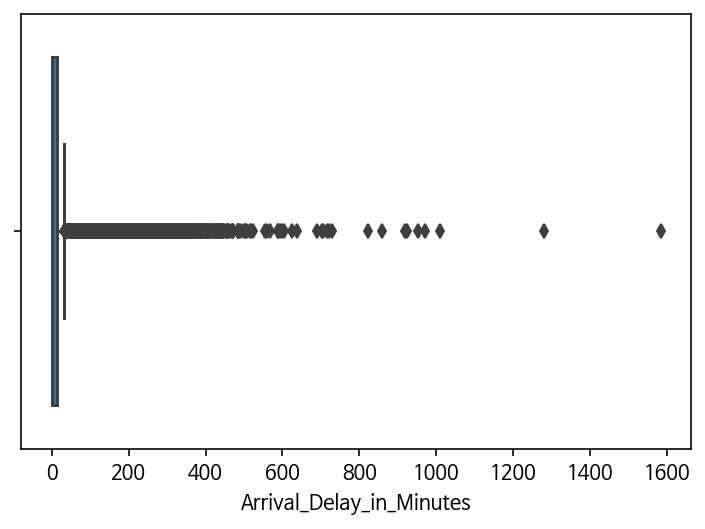

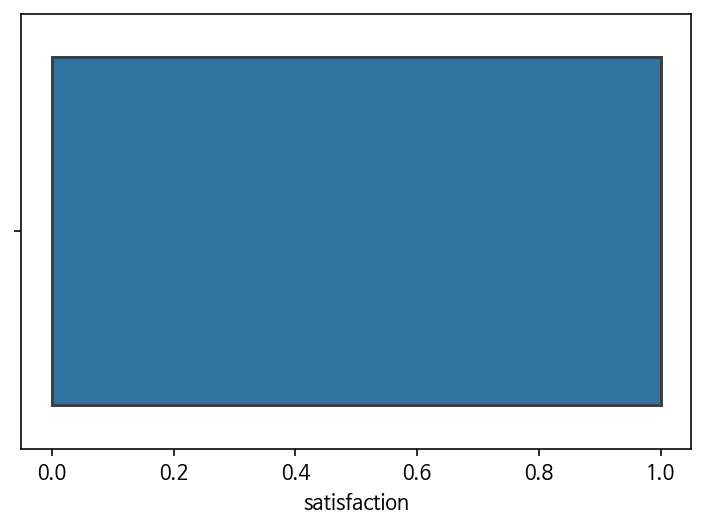

In [445]:
check_outlier(train)

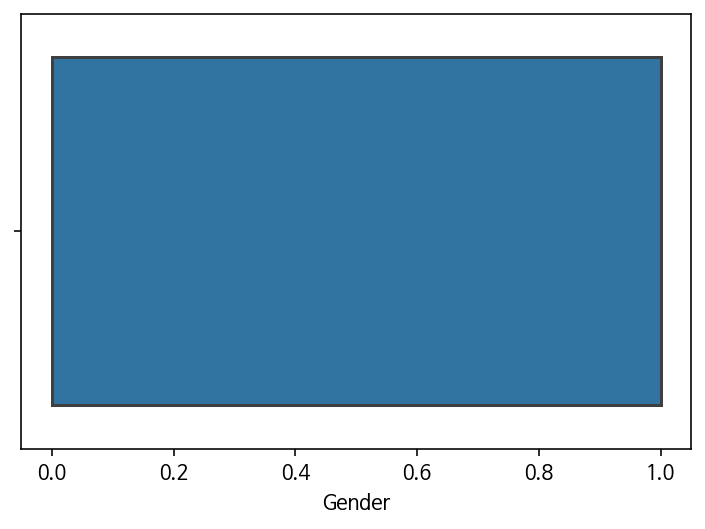

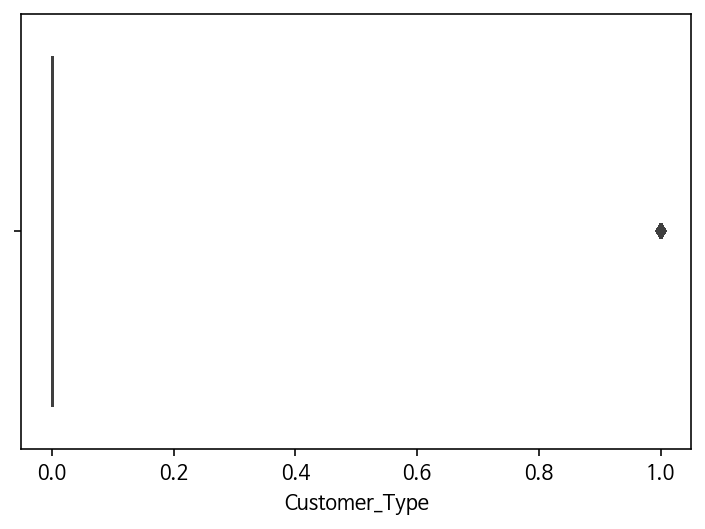

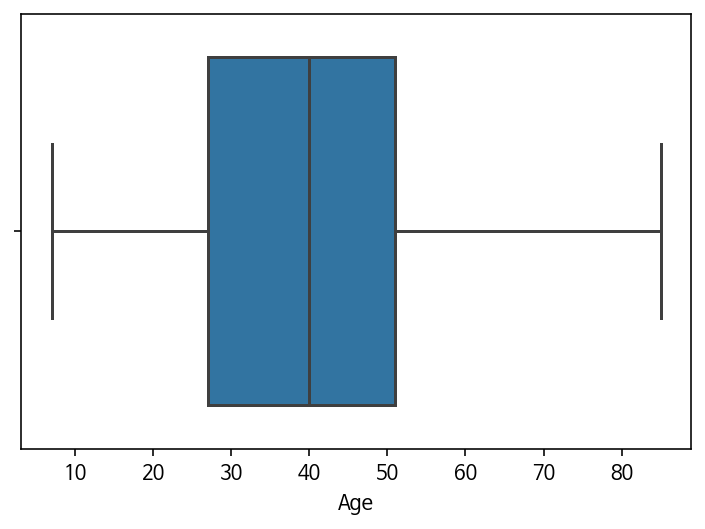

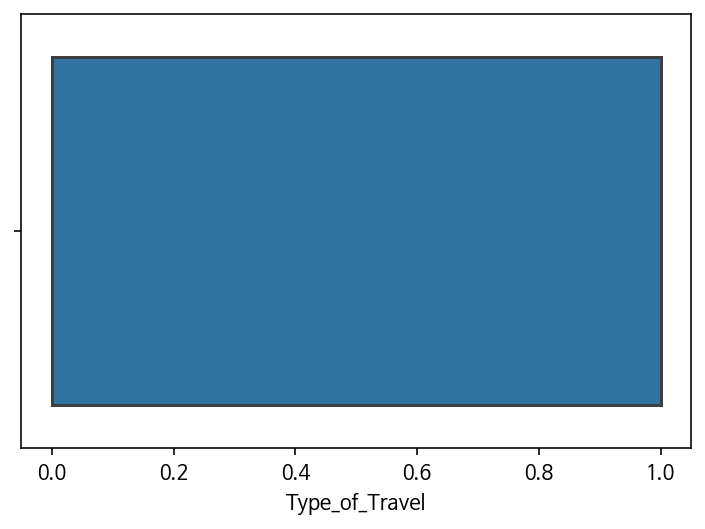

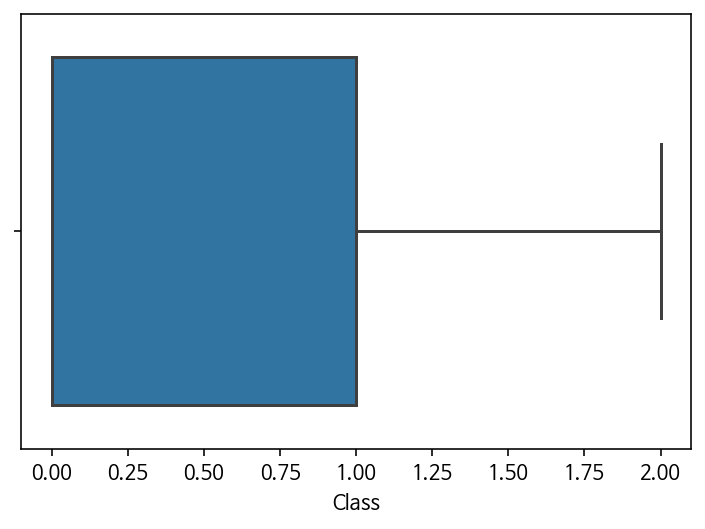

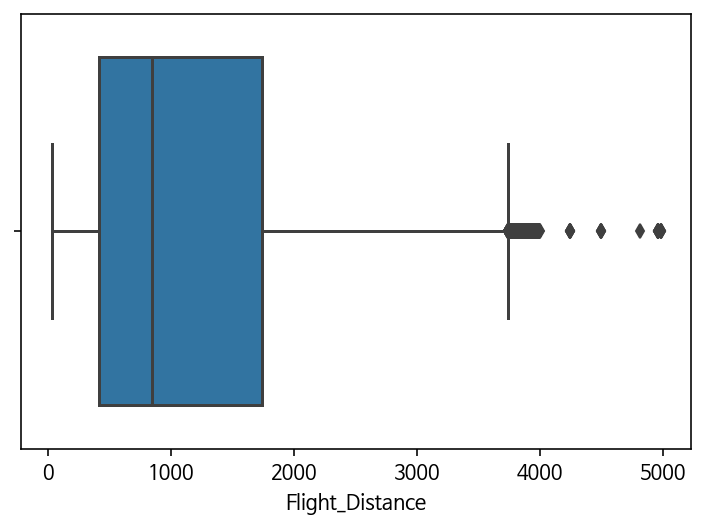

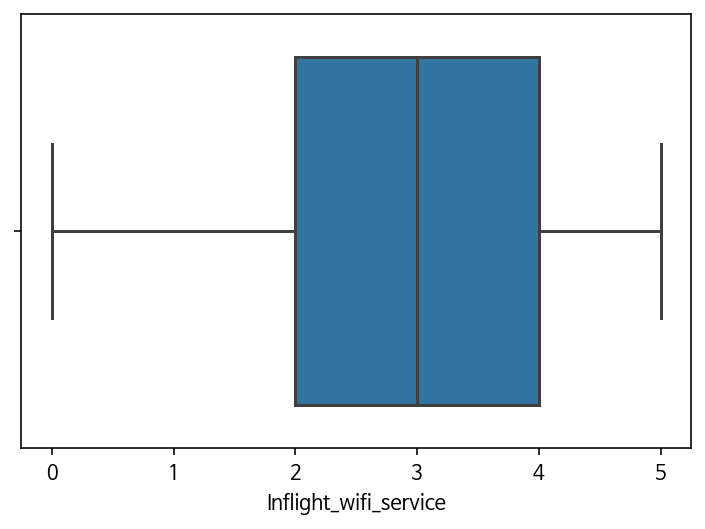

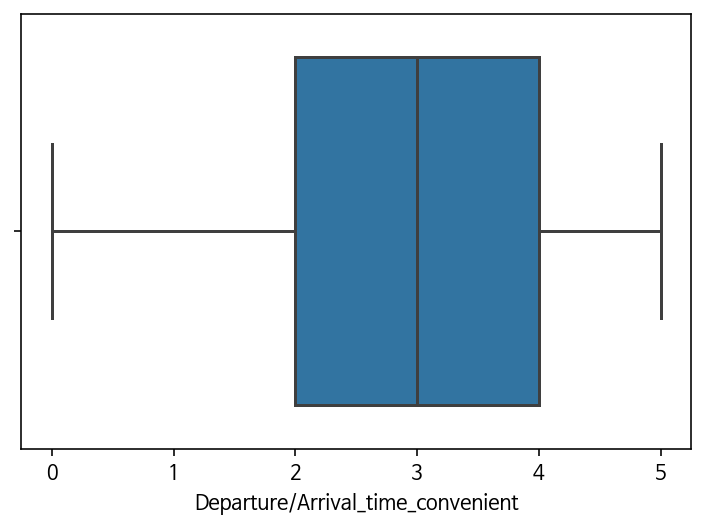

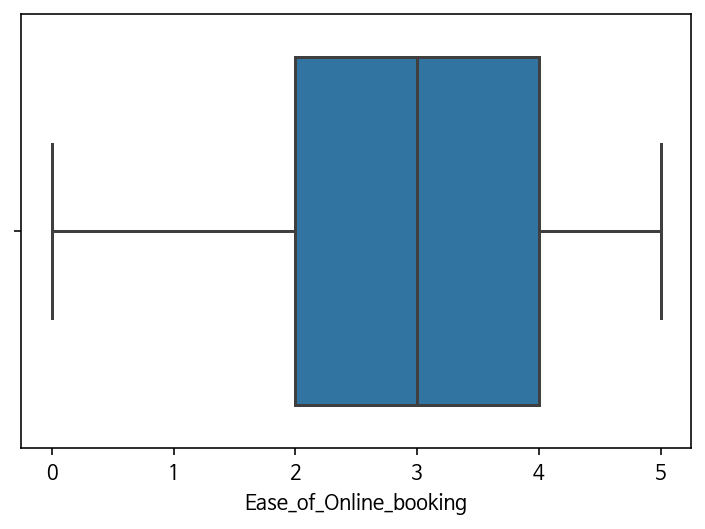

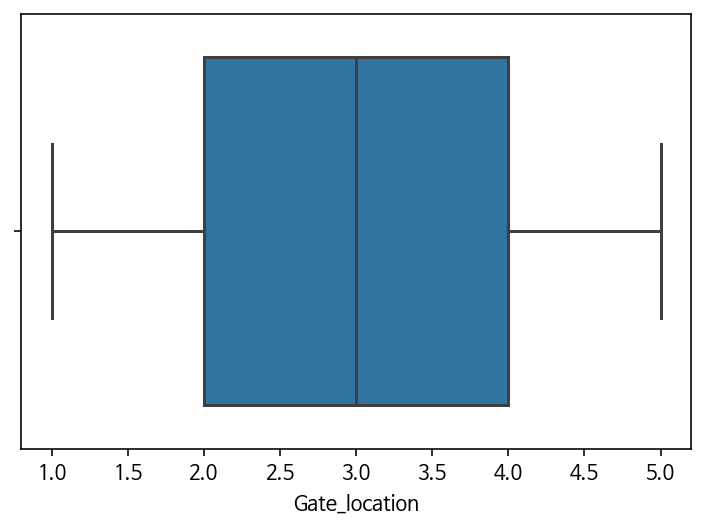

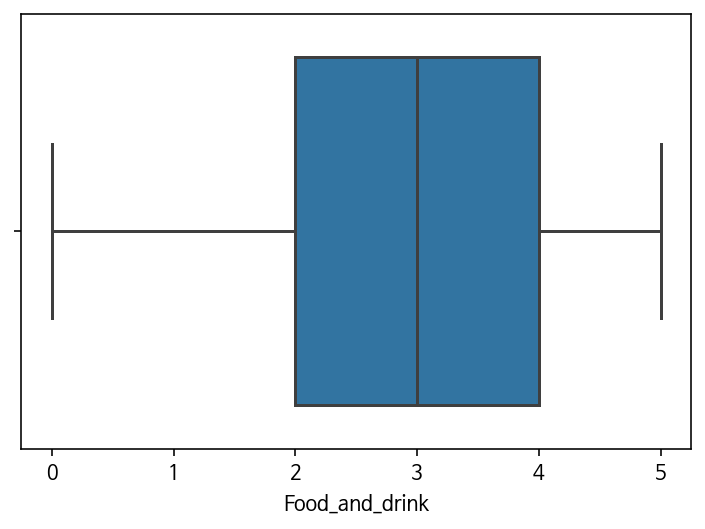

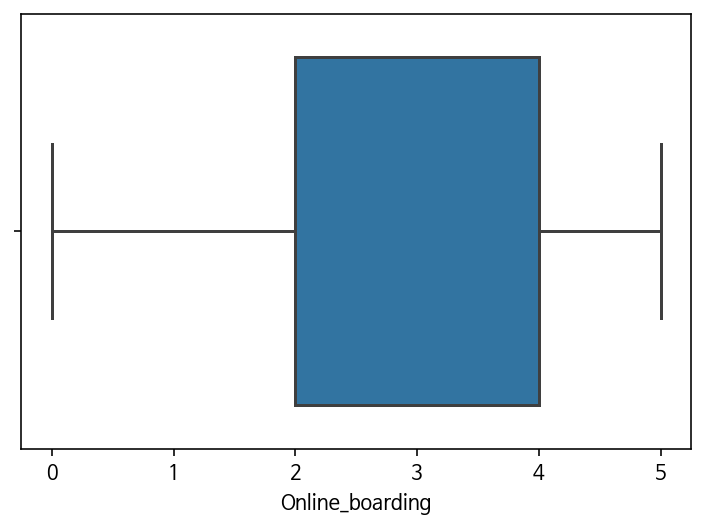

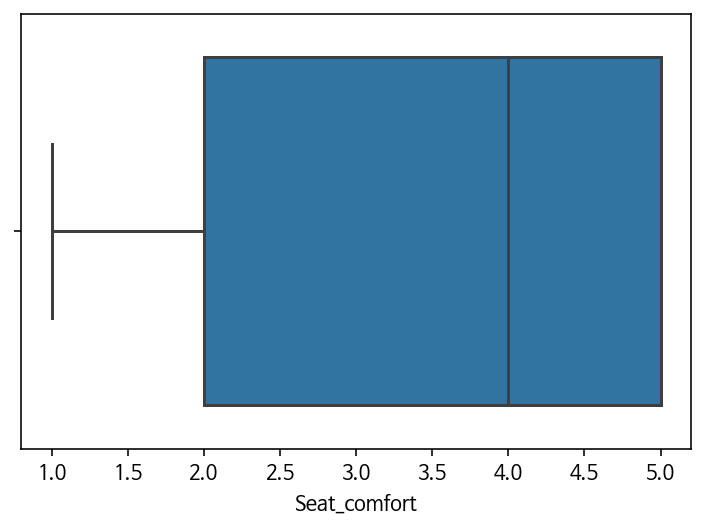

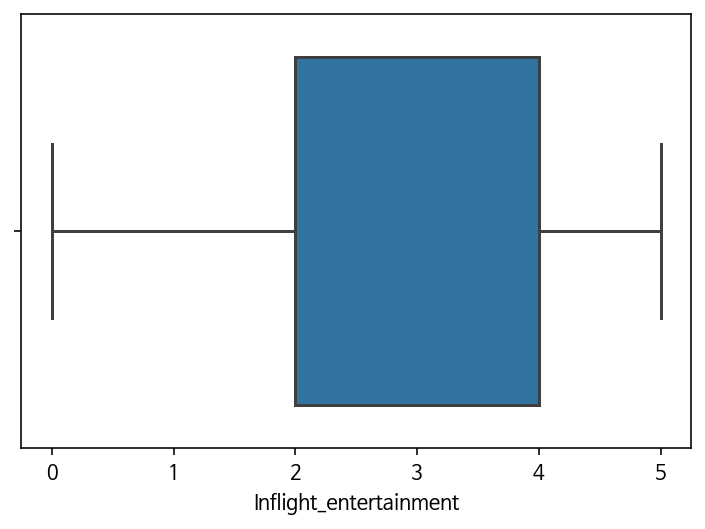

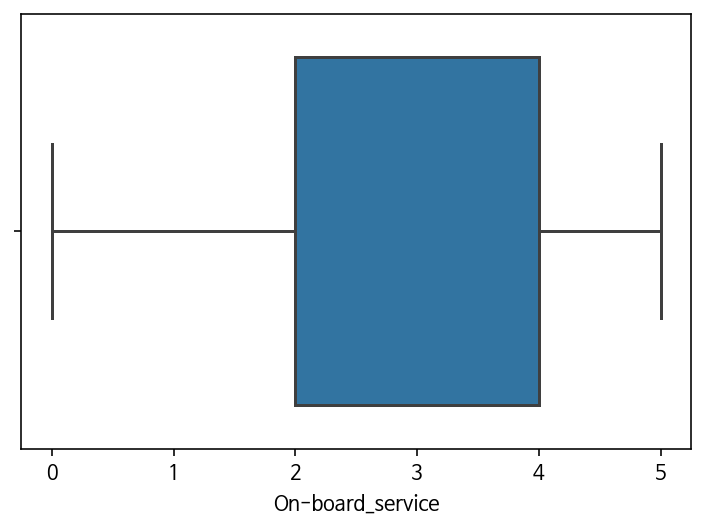

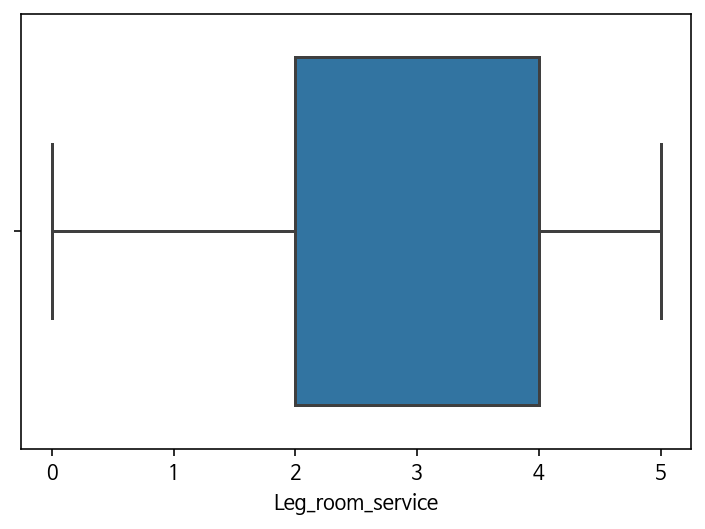

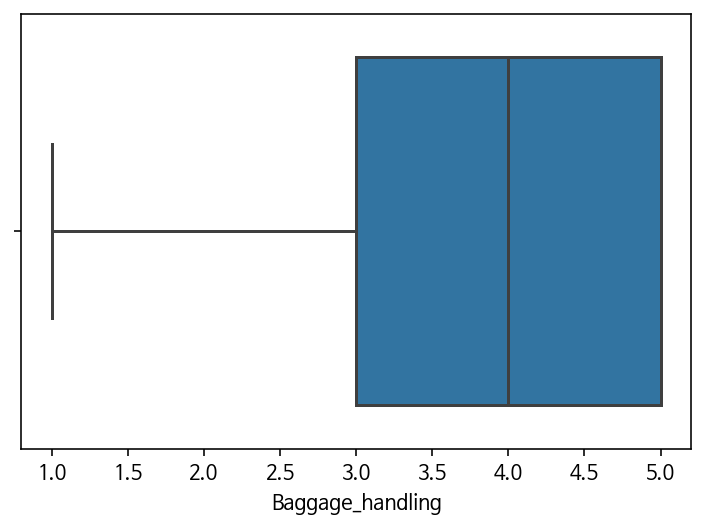

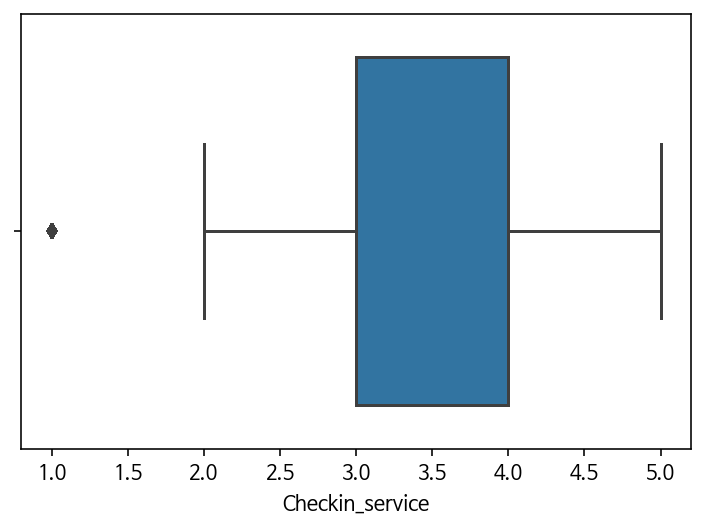

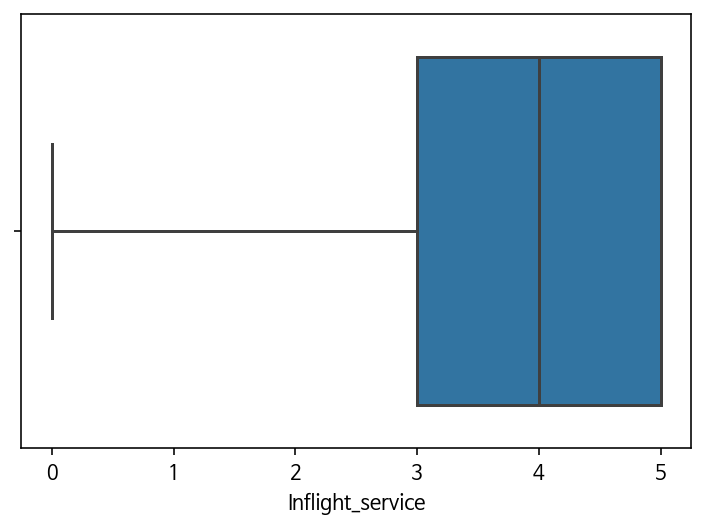

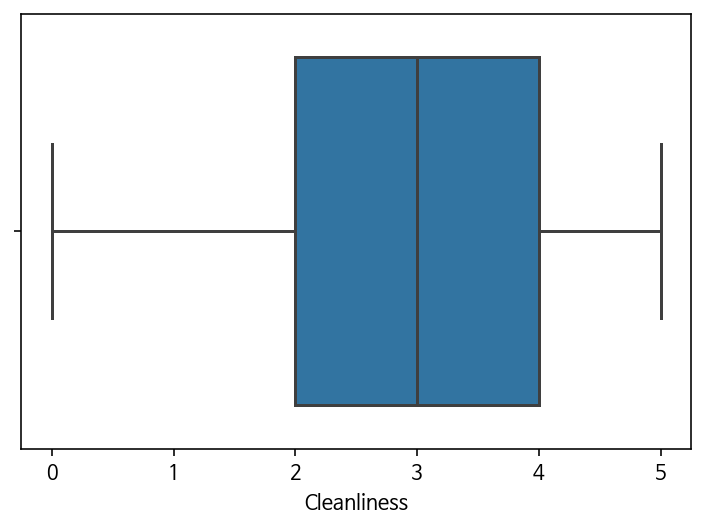

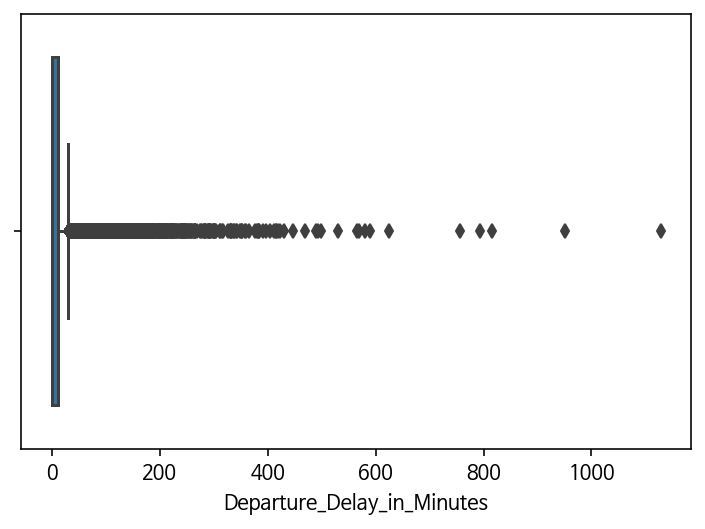

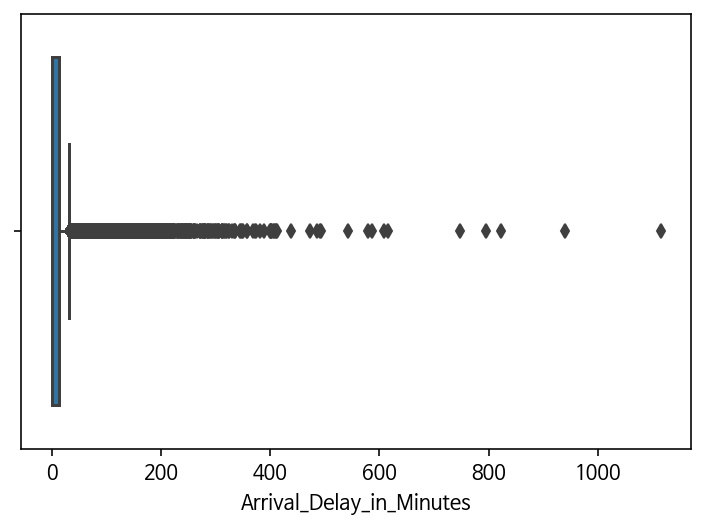

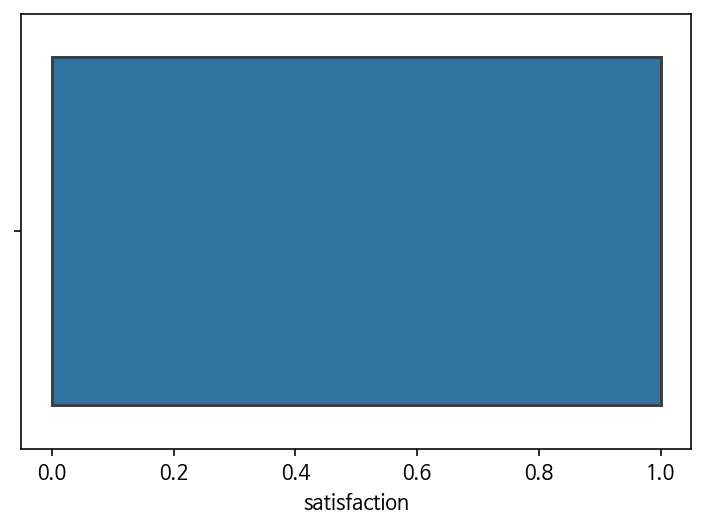

In [446]:
check_outlier(test)

## < 표준화, 정규화 >

In [447]:
train.describe()
##standardization => 1-5 구간처럼 좁은 구간도 있지만 0-1592구간처럼 넓은 구간이 있어 스케일링할 필요가 있다고 판단

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,...,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,0.492541,0.182678,39.379706,0.310373,0.594135,1189.448375,2.729683,3.060296,2.756901,2.976883,...,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.133392,0.433333
std,0.499947,0.386404,15.114964,0.462649,0.620799,997.147281,1.327829,1.525075,1.398929,1.277621,...,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.649776,0.495538
min,0.000000,0.000000,7.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,0.000000,0.000000,414.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,40.000000,0.000000,1.000000,843.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,51.000000,1.000000,1.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,1.000000,1.000000,85.000000,1.000000,2.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


In [448]:
test.describe()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,...,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25976.000000,25976.000000
mean,0.492917,0.184747,39.620958,0.305590,0.592778,1193.788459,2.724746,3.046812,2.756775,2.977094,...,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.693756,0.438982
std,0.499959,0.388100,15.135685,0.460666,0.623703,998.683999,1.335384,1.533371,1.412951,1.282133,...,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.466787,0.496272
min,0.000000,0.000000,7.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,0.000000,0.000000,414.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,40.000000,0.000000,1.000000,849.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,51.000000,1.000000,1.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000,1.000000
max,1.000000,1.000000,85.000000,1.000000,2.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.00000,1115.000000,1.000000


In [449]:
#타겟 속성 제외하고 스케일링
#테스트는 transform만
target = 'satisfaction'
features = train.drop(columns=[target]).columns
scaler = StandardScaler()
scaler.fit(train[features])
scaled_train = scaler.transform(train[features])
scaled_test = scaler.transform(test[features])

In [450]:
transform_train = pd.DataFrame(data = scaled_train, columns = features)
transform_train = pd.concat([transform_train, train['satisfaction']], axis = 1)
transform_train.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1.015031,-0.472767,-1.745279,1.490614,2.264618,-0.731539,0.203579,0.616172,0.173776,-1.547323,...,1.231704,0.479403,-0.26684,0.311769,0.549799,1.156436,1.305870,0.266393,0.074169,0
1,1.015031,2.115208,-0.951360,-0.670865,-0.957054,-0.957184,0.203579,-0.695245,0.173776,0.018094,...,-1.769081,-1.849161,1.25338,-0.535045,-1.821012,0.305848,-1.742292,-0.361375,-0.236313,0
2,-0.985192,-0.472767,-0.885200,-0.670865,-0.957054,-0.047584,-0.549533,-0.695245,-0.541060,-0.764614,...,1.231704,0.479403,-0.26684,0.311769,0.549799,0.305848,1.305870,-0.387532,-0.391554,1
3,-0.985192,-0.472767,-0.951360,-0.670865,-0.957054,-0.629246,-0.549533,1.271880,1.603448,1.583511,...,-1.018885,-1.072973,1.25338,-0.535045,-1.821012,0.305848,-0.980251,-0.099805,-0.158692,0
4,1.015031,-0.472767,1.430397,-0.670865,-0.957054,-0.978244,0.203579,-0.039537,0.173776,0.018094,...,-0.268688,-0.296785,0.49327,0.311769,-0.240472,-0.544740,-0.218211,-0.387532,-0.391554,1


In [451]:
transform_test = pd.DataFrame(data = scaled_test, columns = features)
transform_test = pd.concat([transform_test, test['satisfaction']], axis = 1)
transform_test.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,-0.985192,-0.472767,0.834958,-0.670865,0.653782,-1.032398,1.709804,0.616172,0.173776,0.800803,...,1.231704,1.255590,1.253380,1.158582,-1.030742,1.156436,1.305870,0.920317,0.746880,1
1,-0.985192,-0.472767,-0.223601,-0.670865,-0.957054,1.678348,-1.302646,-1.350954,0.173776,-1.547323,...,0.481508,0.479403,0.493270,0.311769,-0.240472,0.305848,1.305870,-0.387532,-0.391554,1
2,1.015031,2.115208,-1.282160,-0.670865,0.653782,-1.000307,-0.549533,-2.006662,-0.541060,0.800803,...,-1.018885,0.479403,-1.787061,-0.535045,-1.030742,-1.395328,-0.980251,-0.387532,-0.391554,0
3,1.015031,-0.472767,0.305678,-0.670865,-0.957054,2.193821,-2.055758,-2.006662,-1.970731,-0.764614,...,-1.769081,-1.849161,-1.787061,-2.228672,-0.240472,-2.245916,0.543829,-0.387532,-0.236313,1
4,-0.985192,-0.472767,0.636478,-0.670865,0.653782,-0.007470,-0.549533,-0.039537,0.888612,0.018094,...,-1.018885,-1.072973,-1.026951,-1.381858,0.549799,-1.395328,0.543829,-0.387532,0.125916,1


## < 상관관계 >

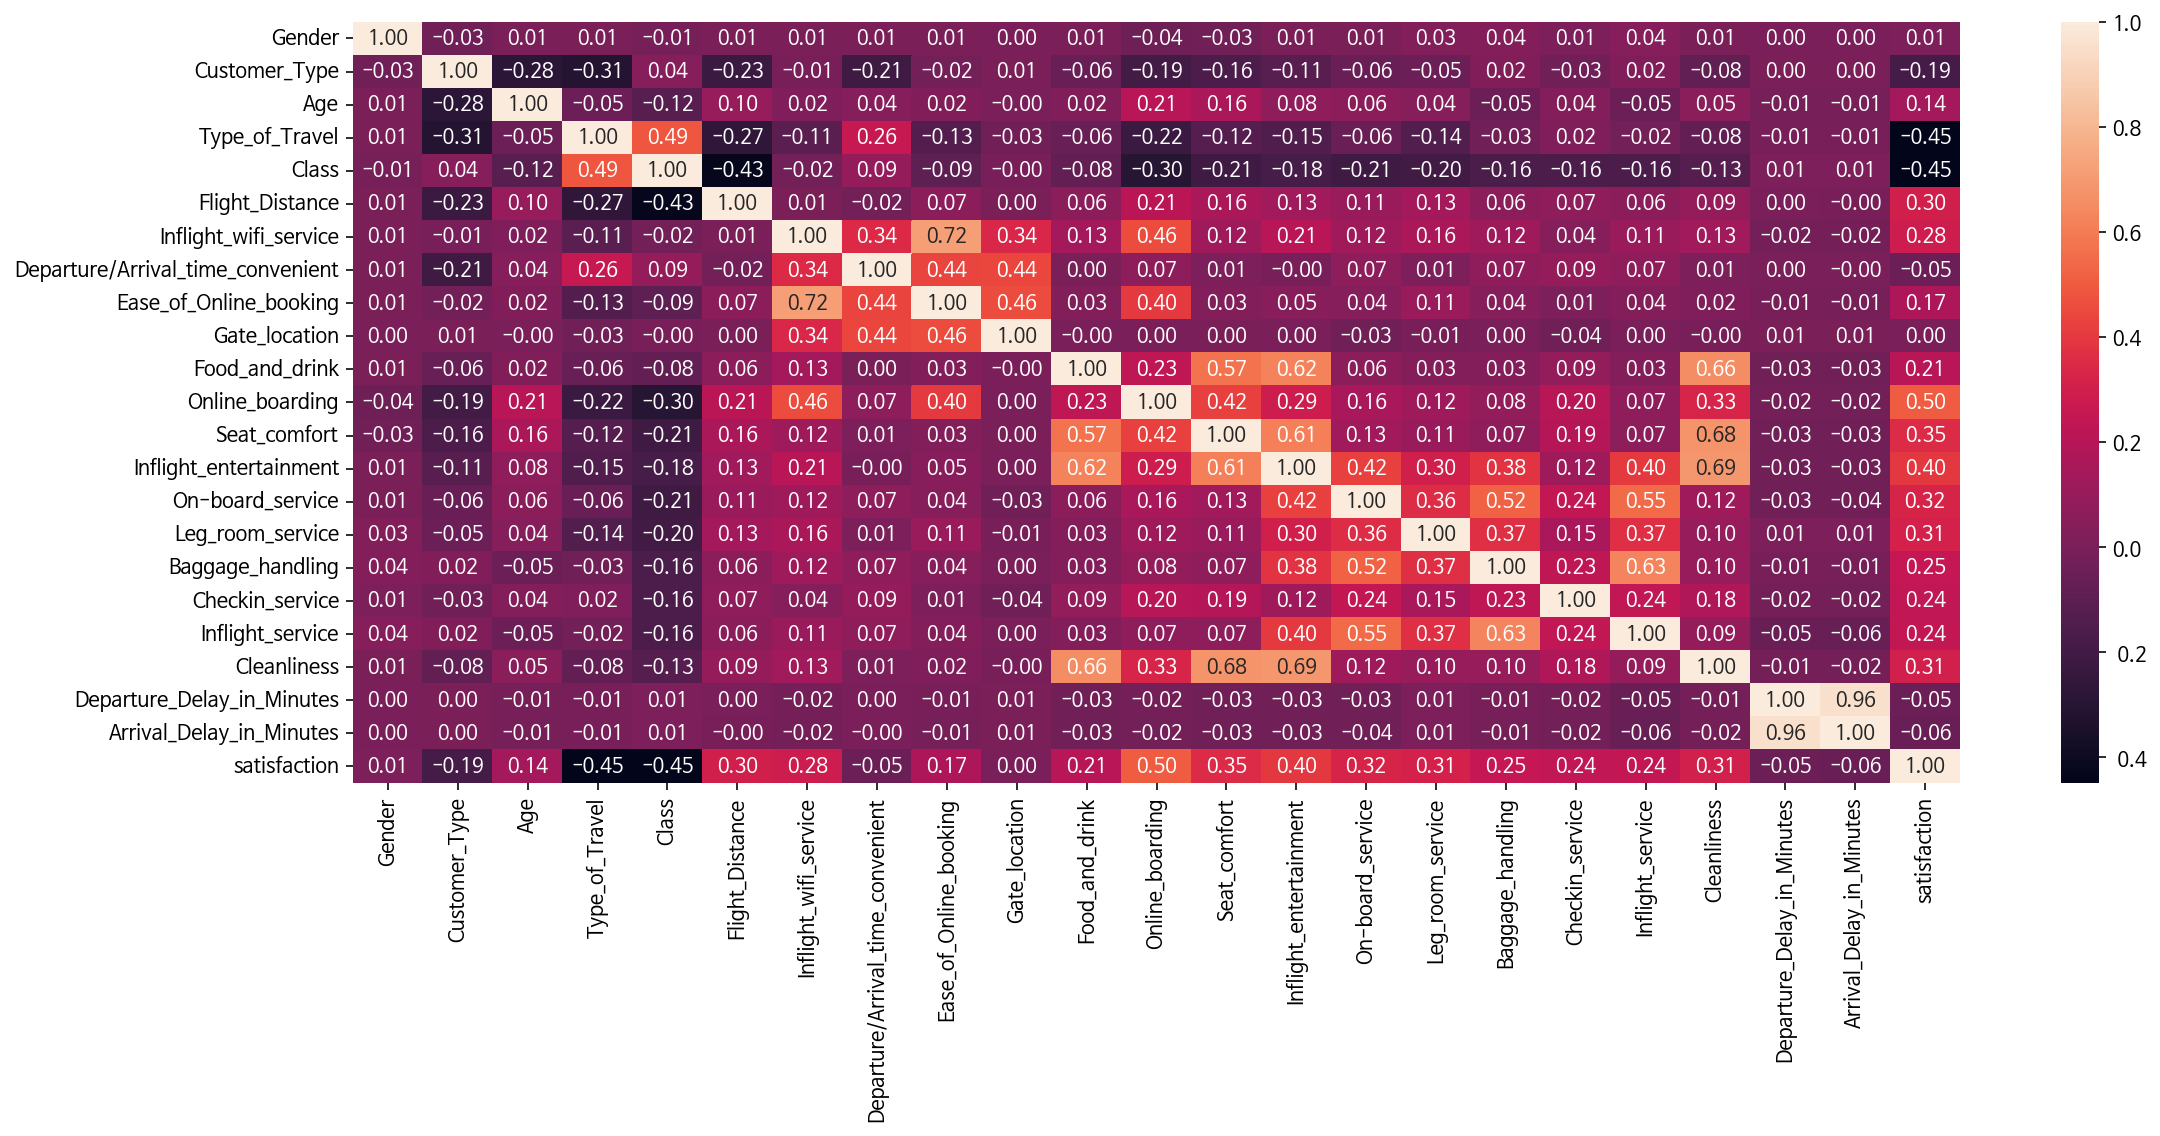

In [452]:
plt.figure(figsize = (18, 7))
sns.heatmap(transform_train.corr(), annot = True, fmt = '0.2f')
plt.show()

## < Train/Test 나누기 >

In [453]:
target = 'satisfaction'
X_train = transform_train.drop(columns = target)
y_train = transform_train[target]
X_test = transform_test.drop(columns = target)
y_test = transform_test[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((103904, 22), (103904,), (25976, 22), (25976,))

## < 특성선택 >

In [460]:
selector = SelectKBest(score_func = f_regression, k = 5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((103904, 5), (25976, 5))

In [461]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask] 

print('Top 5 Features : ', selected_names)

Top 5 Features :  Index(['Type_of_Travel', 'Class', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment'],
      dtype='object')


## < 특성 중요도 >

In [456]:
perm = PermutationImportance(rf(n_estimators=100, random_state=0).fit(X,y),random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

NameError: ignored

## < 순열 중요도 >

## < 모델 만들기 >

## < 결론 >